In [15]:
import os, sys, glob, shutil, json
import cv2
from PIL import Image
import numpy as np

import torch
from torch.utils.data.dataset import Dataset
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

### 制作数据集Dataset类

In [3]:
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None):
        self.img_path = img_path
        self.img_label = img_label
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None
    
    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        # 假设最长字符为5个, 提供的数据集中0为0（原数据集中0为类别10），所以我们可以用10来表示空字符串
        lbl = np.array(self.img_label[index], dtype=np.int)
        lbl = list(lbl) + (5 - len(lbl)) * [10]

        return img, torch.from_numpy(np.array(lbl[:5]))
    
    def __len__(self):
        return len(self.img_path)

In [7]:
lbl = [1, 3, 10]
lbl = list(lbl) + (5 - len(lbl)) * [10]
lbl

[1, 3, 10, 10, 10]

In [4]:
train_path = glob.glob(r'data\mchar_train\*.png')
# glob库读取所有文件
train_path.sort()
train_json = json.load(open(r'data\mchar_train.json'))
train_label = [train_json[x]['label'] for x in train_json]

In [21]:
list(train_json.values())[49]

{'height': [26, 26, 26],
 'label': [1, 0, 3],
 'left': [58, 74, 95],
 'top': [27, 22, 17],
 'width': [11, 15, 15]}

In [38]:
data = SVHNDataset(train_path, train_label, transforms.Compose([
    # 缩放到固定尺寸 PIL的resize函数（可选算法）
    transforms.Resize((64, 128)),
    # 随机颜色变换（4个参数 亮度 对比度 饱和度 色相）
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    # 加入随机旋转（输入的是旋转的度数，从-5度到5度）
    transforms.RandomRotation(5),
    # 将图片转换为pytorch tensor
    transforms.ToTensor(),
    # 将图像像素归一化（对每个通道做z-score）做了之后效果不好
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]))

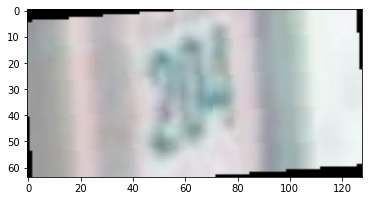

In [43]:
img = data[43][0].numpy()
img = np.transpose(img, (1, 2, 0))
plt.imshow(img)

### 做Dataloader提供批量读取

In [48]:
# 没有zscore
train_loader = torch.utils.data.DataLoader(data, batch_size=32, shuffle=False)


torch.Size([32, 3, 64, 128])


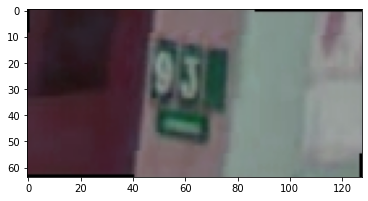

In [58]:
for data in train_loader:
    print(data[0].shape)
    # batch_size*channels*height*width
    img = data[0][3].numpy()
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    break